# 作业#1 语义相似度计算
** **
    姓名 : 夏乔林    
    学号 : 1501214417

## 1. 作业要求
>**实现**5种词汇相似度计算方法**，尽量保证方法的多样性**
>- 基于WordSimilarity-353进行实验和分析  
>	- 基于Spearman’s rank correlation coefficient进行评价  
>    - **set1和set2分开评价**。有监督方法生成set1结果时可用set2作为训练集，生成set2结果时可用set1作为训练集。无监督方法可在任意数据集上调参。  
>
>- 提交压缩文件包到sckr2016.163.com  
>	- 提交：姓名_学号_第一次作业.zip  
>	- codes/：包括自己编写的代码（调用的大型工具包不用提交，只需在报告中说明即可），编程语言不限  
>	- 2～3页小报告，包括调用的**工具**或**资源**，**实验方法**、**结果比较**与**分析**（每种方法在set1、set2、combined数据集上的**[Spearman’s rank correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)值**）、**想法**等  
>	- results/：1~5五个子文件夹，每个子文件夹下包括result1.csv和result2.csv结果文件，格式和顺序分别与set1.csv和set2.csv（前三列）相同，utf8编码  
  
## 2. 资源
**本文主要使用的资源:**

  - **Python NLTK**. 需要通过nltk.download()下载的语料资源有:
    1. infomation content在六个语料库中的结果  
    2. wordnet语料库    

## 3.基础模块实现

### 1). 载入wordnet和基础模块

In [1]:
%matplotlib inline
# 载入wordnet和基础模块
from nltk.corpus import wordnet as wn
from util import set1,set2,comb,write,plotpairs
test_all_results=[]

### 2). 读入WordSimilarity353
除了样本对Pair, 其他详情见代码文件: util.py

In [2]:
# 定义样本对类Pair
class Pair:
    def  __init__(self,word1,word2,mean):
        self.word1=word1
        self.word2=word2
        self.mean=mean
        self.score=0.0
        self.scores=[] # for multiple scores
        self.r1=None # human rank
        self.r2=None # predict rank
        
    def __str__(self):
        return self.word1+','+self.word2+','+str(self.mean)
    
    def check_mean(self,scores):
        m=sum(scores)/float(len(scores))
        #m=float('%.2f'%m0)
        if abs(m-self.mean)>0.006:
            print 'check mean failed!'
            print self,m,m0
            return False
        return True
    
    # 用函数fun计算样本相似度分值
    def sim(self,fun):
        return fun(self.word1,self.word2)

### 3). 评价指标: Spearman's rank correlation coefficient 

代码:

In [3]:
# 由排序后的样本生成rank词典
def sort2rank(pairs, key):
    pairs.sort(key=key)
    sort_pairs=pairs
    i=1
    rank_pairs={}
    for pair in sort_pairs:
        rank_pairs[pair.word1+pair.word2]=i
        i+=1
    return rank_pairs

# 按照Spearman's rank correlation coefficient计算相关系数
def rank_coeff(pairs):
    rank_human=sort2rank(pairs,key= lambda pair:pair.mean)
    rank_predict=sort2rank(pairs,key= lambda pair:pair.score)
    
    d2sum=0
    for i,pair in enumerate(pairs):
        pair.r1=rank_human[pair.word1+pair.word2]
        pair.r2=rank_predict[pair.word1+pair.word2]
        d2=(pair.r1-pair.r2)*(pair.r1-pair.r2)
        d2sum+=d2
    n=len(pairs)
    coeff = 1.0 - float(6*d2sum)/float(n*(n*n-1))
    return coeff

def test_oneset(pairs,fun):
    failed_i=[]
    scores=[]
    for i,pair in enumerate(pairs):
        score=pair.sim(fun)
        if not score:
            failed_i.append(i)
        else:
            pairs[i].score=score
            scores.append(score)
            
    avrg_score=sum(scores)/len(scores)
    for i in failed_i:
        pairs[i].score=avrg_score
    
    return pairs

def test(fun,test_name):
    global test_all_results
    pairs=test_oneset(set1(),fun)
    coeff1=rank_coeff(pairs)
    
    pairs=test_oneset(set2(),fun)
    coeff2=rank_coeff(pairs)
    
    pairs=test_oneset(comb(),fun)
    coeff=rank_coeff(pairs)
    
    plotpairs(pairs,coeff,test_name)
    test_all_results.append([coeff1,coeff2,coeff])

### 4). 结果可视化

详情见代码文件: util.py

## 4. 相似度计算方法

### 最短路径方法

- **基本思想**   
    
        两个词在词典层次结构中越相近邻, 这两个词越相似. (i.e.具有比较短的路径). 
        例子如图:
<img src='path.jpg'>  

- **实现方法**  
    
        计算公式如下:
<img src='path_math.jpg'>  

- **代码**    

153 were loaded from set1
200 were loaded from set2
353 were loaded from combined


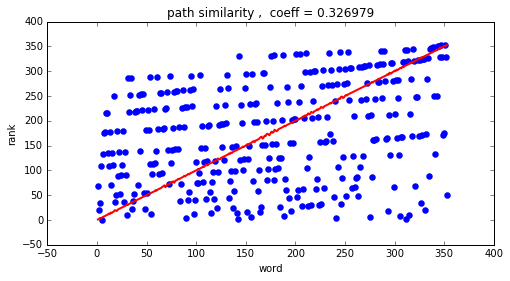

In [4]:
import math
def logpath_sim(s1,s2):
    distance=s1.shortest_path_distance(s2, simulate_root=True and s1._needs_root())
    if distance is None or distance<0:
        return None
    return -math.log(distance+1)

def path(word1,word2):
    synsets1=wn.synsets(word1)
    synsets2=wn.synsets(word2)
    scores=[]
    for s1 in synsets1:
        for s2 in synsets2:
            #print s1.pos(),s2.pos()
            if s1.pos()==s2.pos():
                score=logpath_sim(s1,s2)
                if score:
                    scores.append(score)
    if not scores:
        return None
    return max(scores)
            
test(path,'path')

### 基于信息内容的三个方法: Resnik, Lin, Jiang-Conrath
需要使用外部语料得到infomation content数据.
这里我们通过nltk下载6个语料库的数据. 

- **基本思想** 
 
      衡量两个词的共性为两个词节点的最低公共祖先节点的信息内容(info content).  
    
    
- **实现方法**
    
    **1. Resnik  **

        定义P(C) 从一个语料库中随机选择一个词，这个词属于概念C的概率。
            易知P(root)=1
            计算P(C)的方法: 
    <img src="pc.jpg">
        定义LCS(c1,c2) 最低公共祖先节点(Lowest common subsumer)。 
    
        定义IC(c) 信息内容: IC(c) = -log P(c)。
        
        Resnik相似度公式: 
    <img src="res.jpg">
    
    **2. Lin  **

        与Resnik基本相同, 只是分子乘2, 并多了正则项: description(c1,c2)=log P(c1) + log P (c2)
        
        Lin相似度公式:  
    <img src="lin.jpg">
        
    **2. Jiang-Conrath  **

        与Resnik和Lin基本相同
        
        Jiang-Conrath相似度公式:  
    <img src="jcn.jpg">

- **代码**     

In [5]:
from nltk.corpus import wordnet_ic
import nltk.corpus.reader.wordnet as nltk_reader
ic_files=['ic-bnc.dat', 'ic-brown.dat', 'ic-semcor.dat', 
          'ic-semcorraw.dat', 'ic-shaks.dat', 'ic-treebank.dat']
ics=[wordnet_ic.ic(f) for f in ic_files]
unsupport_pos=[set() for ic in ic_files]
_INF=1e300

#获得IC(LCS(c1,c2))
def ic1_ic2_lcs_ic(synset1,synset2,ic):
    ic1 = nltk_reader.information_content(synset1, ic)
    ic2 = nltk_reader.information_content(synset2, ic)
    #获得祖先节点
    subsumers = synset1.common_hypernyms(synset2)
    if len(subsumers) == 0:
        subsumer_ic = 0
    else:
        subsumer_ic = max(nltk_reader.information_content(s, ic) for s in subsumers)

    return ic1, ic2, subsumer_ic

153 were loaded from set1
200 were loaded from set2
353 were loaded from combined


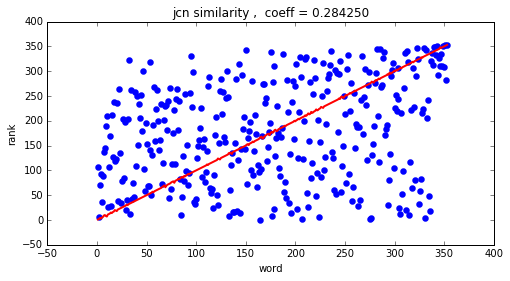

153 were loaded from set1
200 were loaded from set2
353 were loaded from combined


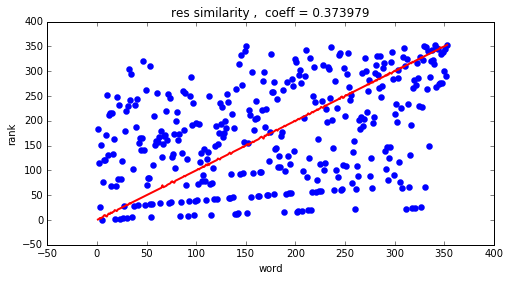

153 were loaded from set1
200 were loaded from set2
353 were loaded from combined


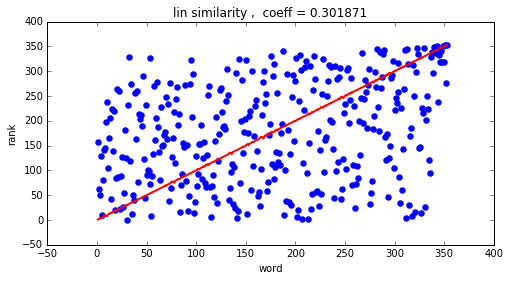

In [6]:
def res(word1,word2):
    def res_fun(synset1,synset2,ic):
        ic1, ic2, lcs_ic = ic1_ic2_lcs_ic(synset1,synset2, ic)
        return lcs_ic
    return ic_sim(word1,word2,res_fun)

def lin(word1,word2):
    def lin_fun(synset1,synset2,ic):
        ic1, ic2, lcs_ic = ic1_ic2_lcs_ic(synset1,synset2, ic)
        return (2.0 * lcs_ic) / (ic1 + ic2)
    return ic_sim(word1,word2,lin_fun)

def jcn(word1,word2):
    def jcn_fun(synset1,synset2,ic):
        ic1, ic2, lcs_ic = ic1_ic2_lcs_ic(synset1,synset2, ic)
        if ic1 == 0 or ic2 == 0:
            return 0
        ic_difference = ic1 + ic2 - 2 * lcs_ic
        if ic_difference == 0:
            return _INF
        return 1.0 / ic_difference
    return ic_sim(word1,word2,jcn_fun)

# 三种方法的通用计算框架
def ic_sim(word1,word2,fun):
    global lc_files,ics,unsupport_pos
    synsets1=wn.synsets(word1)
    synsets2=wn.synsets(word2)
    ret_scores=[]
    for i,ic in enumerate(ics):
        scores=[]
        for s1 in synsets1:
            for s2 in synsets2:
                if s1.pos()==s2.pos() and s1._pos not in unsupport_pos[i]:
                    try:
                        icpos=ic[s1._pos]
                    except KeyError:
                        unsupport_pos[i].add(s1._pos)
                        #print  'Information content file has no entries for part-of-speech: %s in %s'%(s1._pos,ic_files[i])
                        continue
                    score=fun(s1,s2,ic)
                    if score:
                        scores.append(score)
        if not scores:
            #print 'cannot get similarity between %s and %s from %s' %(word1,word2,ic_files[i])
            continue
        ret_scores.append(max(scores))
    if not ret_scores:
        return None
    return sum(ret_scores)/len(ret_scores)

test(jcn,'jcn')
test(res,'res')
test(lin,'lin')

### Leacock-Chodorow 和 Wu-Palmer方法
此处做简单实现,仅将结果用于后面的机器学习,因此不详细介绍.

In [7]:
# Leacock-Chodorow方法
def lch(word1,word2):
    synsets1=wn.synsets(word1)
    synsets2=wn.synsets(word2)
    scores=[]
    for s1 in synsets1:
        for s2 in synsets2:
            #print s1.pos(),s2.pos()
            if s1.pos()==s2.pos():
                score=s1.lch_similarity(s2)
                if score:
                    scores.append(score)
    if not scores:
        return None
    return max(scores)

#test(lch,'lch')

# Wu-Palmer方法
def wup(word1,word2):
    synsets1=wn.synsets(word1)
    synsets2=wn.synsets(word2)
    scores=[]
    for s1 in synsets1:
        for s2 in synsets2:
            #print s1.pos(),s2.pos()
            if s1.pos()==s2.pos():
                score=s1.wup_similarity(s2)
                if score:
                    scores.append(score)
    if not scores:
        return None
    return max(scores)
            
#test(wup,'wup')

### 机器学习综合方法

- **基本思想** 
 
      由上面的结果我们可以看出, 每种方法单一的使用,都不能达到良好效果. 
      我们借助线性回归模型,以每种单一方法的输出作为特征分量, 就可以得到一个效果相对更好的结果.
    
    
- **实现方法**
    
    **线性回归模型  **

     - 输入: 
        [X]=( X1, X2, ...,Xm), 
        *其中, Xi=(f1,f2, ... fn), m是样本数, n是所使用的单一方法总数*
     - 输出:
        [Y]=( Y1, Y2, ...,Ym)
   

- **代码**     

153 were loaded from set1
200 were loaded from set2


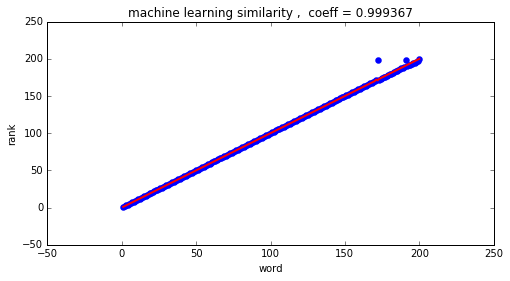

200 were loaded from set2
153 were loaded from set1


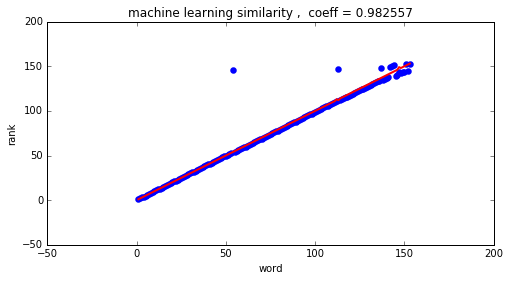

In [8]:
import numpy as np
from sklearn import datasets, linear_model

class Model:
    def __init__(self,trainset,testset,
                feature_funs):
        self.trainset=trainset
        self.testset=testset
        self.feature_funs=feature_funs
        self.regr = linear_model.LinearRegression()

    def evaluate(self, train=False):
        if train:
            pairs=self.trainset
        else:
            pairs=self.testset
        for fun in self.feature_funs:
            failed_i=[]
            scores=[]
            for i,pair in enumerate(pairs):
                score=pair.sim(fun)
                if not score:
                    failed_i.append(i)
                else:
                    pairs[i].scores.append(score)
                    scores.append(score)
            avrg_score=sum(scores)/len(scores)
            for i in failed_i:
                pairs[i].scores.append(score)
        X=np.array([pair.scores for pair in pairs])
        #print X.shape
        Y=np.array([pair.mean for pair in pairs])
        
        if train:
            self.regr.fit(X, Y)
        else:
            Y_predict=self.regr.predict(X)
            for i,pair in enumerate(pairs):
                pairs[i].score=Y_predict[i]
            coeff=rank_coeff(pairs)
            plotpairs(pairs,coeff,'machine learning')
            test_all_results.append(coeff)
            return coeff
    
    def train_test(self):
        self.evaluate(True)
        coeff=self.evaluate(False)
        return coeff

def mltest():        
    model=Model(set1(),set2(),[path,res,lin,jcn,lch,wup])
    coeff2=model.train_test()

    model=Model(set2(),set1(),[path,res,lin,jcn,lch,wup])
    coeff1=model.train_test()

    coeff=(coeff1*153.0+coeff2*200.0)/353
    test_all_results.append([coeff1,coeff2,coeff])

mltest()

## 5. 结果比较与分析

**结果如下表所示：**
<table>
    <tr>
        <th>方法</th>
        <th>coeff on set1</th>
        <th>coeff on set2</th>
        <th>coeff on combined</th>
    </tr>
	<tr>
        <td>Path</td>
		<td>0.311053368716</td>
		<td>0.308401710043</td>
		<td>0.326979265333</td>
	</tr>
	<tr>
        <td>Resnik</td>
		<td>0.36616775897</td>
		<td>0.167585689642</td>
		<td>0.284250366657</td>
	</tr>
	<tr>
        <td>Lin</td>
		<td>0.419596786083</td>
		<td>0.284402610065</td>
		<td>0.3739790078</td>
	</tr>
	<tr>
        <td>Jiang-Conrath </td>
		<td>0.36104800772</td>
		<td>0.203012075302</td>
		<td>0.301871450739</td>
	</tr>
	<tr>
        <td>Machine Learning</td>
		<td>0.982556659027</td>
		<td>0.999366984175</td>
		<td>0.992080922567</td>
	</tr>
</table>

### 分析
   - 从上表可以很明显的发现，无监督单一的方法在评价相似度的准确性上表现并不好。  
   - 相对而言，机器学习的方法表现最佳。  
   - 在无监督的几种方法当中，表现最差的是基于信息内容的Resnik方法，而设计最为简单的基于Path的方法并没有想象中那么差。  
   - 但在无监督的集中方法当中，表现最好的也是基于信息内容的改进方法Lin方法。这也说明信息内容在评价语义相似性上也是存在一定作用的。但是效果取决于我们如何利用它。  
   - 通过这个实验，我们可以得出结论，使用机器学习的方法将多种单一无监督方法的结果结合起来训练模型，可以很显著的提高Spearman’s rank相关系数。因此，在实际应用当中，我们也可以采取这种综合的方法。  
